Functions Defined.
Date-Time:  2023-11-22_16-41
Successfully opened gamma data!
Successfully opened proton data!
Shape of Tel1:  (4000,)
Shape of Tel2:  (4000,)
Shape of Tel3:  (4000,)
Shape of Tel4:  (4000,)
Shape of Labels:  (4000,)
Labels:  [1 1 1 ... 0 0 0]
/home/hanneswarnhofer/ECAP_HiWi_WorkingDirectory
[2080 2667  178 1307 3033    9 2467  722 2896  170]
Start Mapping...
... Finished Mapping
Shape of mapped_images_1:  (1000, 41, 41, 1)
Shape of mapped_images:  (4, 1000, 41, 41, 1)
New shape of mapped_images:  (1000, 4, 41, 41)
New shape of mapped_labels:  (1000, 1)
1000  events with 4 images each are available 

Shape of 'event_labels':  (1000, 1)
Shape of 'peak_times':  (1000, 4, 41, 41, 1) 

[False  True  True  True  True  True  True  True  True  True]
Split into Training and Test Data
Train data shape: (816, 4, 41, 41, 1) --> 81.6 %
Test data shape: (184, 4, 41, 41, 1) --> 18.4 %
Train labels shape: (816, 1)
Test labels shape: (184, 1)
(2615, 41, 41, 1)
(2615, 1)
Plotting Exam

/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


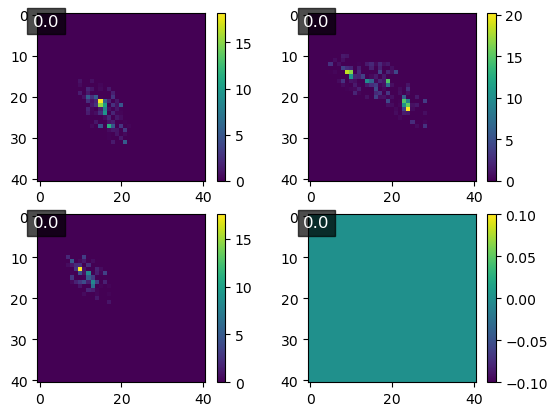

Min. and Max. Value for Image 1:  0.0  -  18.23650360107422 . Sum:  176.43749363720417
Min. and Max. Value for Image 2:  0.0  -  20.224853515625 . Sum:  299.62553171347827
Min. and Max. Value for Image 3:  0.0  -  17.547975540161133 . Sum:  112.38035589084029
Min. and Max. Value for Image 4:  0.0  -  0.0 . Sum:  0.0
Plotting Example Event. Event Nr:  4


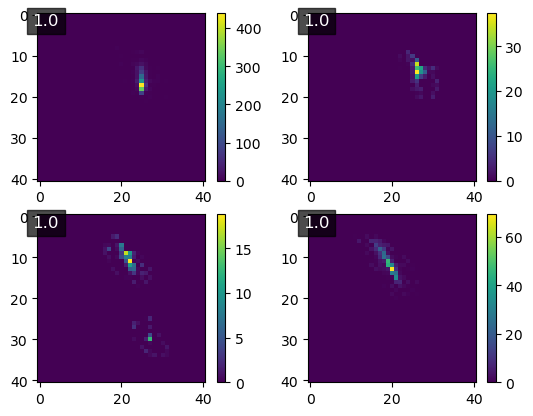

Min. and Max. Value for Image 1:  0.0  -  440.7603759765625 . Sum:  1909.082238741219
Min. and Max. Value for Image 2:  0.0  -  37.53883743286133 . Sum:  273.62550539243966
Min. and Max. Value for Image 3:  0.0  -  18.80051612854004 . Sum:  191.26580851897597
Min. and Max. Value for Image 4:  0.0  -  69.34878540039062 . Sum:  585.4365524118766


In [4]:

import tables
import tables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import random

import fnmatch
import os
#import h5
import glob
import pickle
import sys
import argparse
import h5py
import os.path
import inspect
import json

from datetime import datetime
import time

from ctapipe.io import EventSource
from ctapipe import utils
from ctapipe.instrument.camera import CameraGeometry

from dl1_data_handler.reader import DL1DataReader
from dl1_data_handler.image_mapper import ImageMapper

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Lambda,Reshape,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

class DataManager():
    """ Data class used to manage the HDF5 data files (simulations + Auger data).
        data_path: data_path of HDF5 file, (hint: use blosc compression to ensure adequate decompression speed,
        to mitigate training bottleneck due to a slow data pipeline)
        params:
            data_path = path to HDF5 datset
        optional params:
            stats: data statistics (stats.json - needed for scaling the dataset)
            tasks: list of tasks to be included (default: ['axis', 'core', 'energy', 'xmax'])
            generator_fn: generator function used for looping over data, generator function needs to have indices and
                          shuffle args.
            ad_map_fn: "advanced mapping function" the function used to map the final dataset. Here an additional
                       preprocessing can be implemented which is mapped during training on the
                       cpu (based on tf.data.experimental.map_and_batch)
    """

    def __init__(self, data_path, stats=None, tasks=['axis', 'impact', 'energy', 'classification']):
        ''' init of DataManager class, to manage simulated (CORSIKA/Offline) and measured dataset '''
        current_timestamp = int(time.time())
        np.random.seed(current_timestamp)
        self.data_path = data_path

    def open_ipython(self):
        from IPython import embed
        embed()

    @property
    def is_data(self):
        return self.type == "Data"

    @property
    def is_mc(self):
        return self.type == "MC"

    def get_h5_file(self):
        return h5py.File(self.data_path, "r")

    def walk_tree(self, details=True):
        """ Draw the tree of yout HDF5 file to see the hierachy of your dataset
            params: detail(activate details to see shapes and used compression ops, Default: True)
        """

        def walk(file, iter_str=''):
            try:
                keys = file.keys()
            except AttributeError:
                keys = []

            for key in keys:
                try:
                    if details:
                        file[key].dtype
                        print(iter_str + str(file[key]))
                    else:
                        print(iter_str + key)
                except AttributeError:
                    print(iter_str + key)
                    walk(file[key], "   " + iter_str)

        with h5py.File(self.data_path, "r") as file:
            print("filename:", file.filename)
            for key in file.keys():
                print(' - ' + key)
                walk(file[key], iter_str='   - ')

    def extract_info(self, path):
        with self.get_h5_file() as f:
            data = f[path]
            y = np.stack(data[:].tolist())

        return {k: y[:, i] for i, k in enumerate(data.dtype.names)}, dict(data.dtype.descr)

    def make_mc_data(self):
        return self.extract_info("simulation/event/subarray/shower")




def re_index_ct14(image):
    return image[5:, :, :]

def make_hess_geometry(file=None):
    # quick fix for dl1 data handler to circumvent to use ctapipe
    if file is None:
        with open(os.path.join(os.getcwd(), "geometry2d3.json")) as f: 
            attr_dict = json.load(f)

        data_ct14 = attr_dict["ct14_geo"]
        data_ct5 = attr_dict["ct5_geo"]
    else:
        data_ct14 = file["configuration/instrument/telescope/camera/geometry_0"][:].tolist()
        data_ct5 = file["configuration/instrument/telescope/camera/geometry_1"][:].tolist()

    class Geometry():
        def __init__(self, data):
            self.pix_id, self.pix_x, self.pix_y, self.pix_area = np.stack(data).T.astype(np.float32)
            self.pos_x = self.pix_x
            self.pos_y = self.pix_y

        def get_pix_pos(self):
            return np.column_stack([self.pix_x, self.pix_y]).T

    return Geometry(data_ct14), Geometry(data_ct5)

def get_current_path():
    filename = inspect.getframeinfo(inspect.currentframe()).filename
    return os.path.dirname(os.path.abspath(filename))

def rotate(pix_pos, rotation_angle=0):
    rotation_angle = rotation_angle * np.pi / 180.0
    rotation_matrix = np.matrix([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                                [np.sin(rotation_angle), np.cos(rotation_angle)], ], dtype=float)

    pixel_positions = np.squeeze(np.asarray(np.dot(rotation_matrix, pix_pos)))
    return pixel_positions

def plot_image_2by2(train_data,event_nr,labels,string,dt):

    

    

    print("Plotting Example Event. Event Nr: ", event_nr)

    image1 = train_data[:,0,:,:] 
    image2 = train_data[:,1,:,:] 
    image3 = train_data[:,2,:,:] 
    image4 = train_data[:,3,:,:] 

    pltimage1 = image1[event_nr]
    pltimage2 = image2[event_nr]
    pltimage3 = image3[event_nr]
    pltimage4 = image4[event_nr]

    fig, ax = plt.subplots(2,2)

    im1 = ax[0,0].imshow(pltimage1[:,:,0], cmap='viridis',vmin=0)
    im2 = ax[0,1].imshow(pltimage2[:,:,0], cmap='viridis',vmin=0)
    im3 = ax[1,0].imshow(pltimage3[:,:,0], cmap='viridis',vmin=0)
    im4 = ax[1,1].imshow(pltimage4[:,:,0], cmap='viridis',vmin=0)

    cbar1 = fig.colorbar(im1, ax=ax[0, 0], orientation='vertical')
    cbar2 = fig.colorbar(im2, ax=ax[0, 1], orientation='vertical')
    cbar3 = fig.colorbar(im3, ax=ax[1, 0], orientation='vertical')
    cbar4 = fig.colorbar(im4, ax=ax[1, 1], orientation='vertical')


    label1 = labels[event_nr].ravel()[0]
    label2 = labels[event_nr].ravel()[1]
    label3 = labels[event_nr].ravel()[2]
    label4 = labels[event_nr].ravel()[3]

    str_label1 = '{}'.format(label1)
    str_label2 = '{}'.format(label2)
    str_label3 = '{}'.format(label3)
    str_label4 = '{}'.format(label4)

    ax[0, 0].text(0.05, 0.95, str_label1, transform=ax[0, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[0, 1].text(0.05, 0.95, str_label2, transform=ax[0, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 0].text(0.05, 0.95, str_label3, transform=ax[1, 0].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    ax[1, 1].text(0.05, 0.95, str_label4, transform=ax[1, 1].transAxes, color='white', fontsize=12, ha='center', va='center', bbox=dict(facecolor='black', alpha=0.7))
    plt.show()

    print("Min. and Max. Value for Image 1: ", np.min(pltimage1), " - " , np.max(pltimage1) , ". Sum: ", np.sum(pltimage1))
    print("Min. and Max. Value for Image 2: ", np.min(pltimage2), " - " , np.max(pltimage2), ". Sum: ", np.sum(pltimage2))
    print("Min. and Max. Value for Image 3: ", np.min(pltimage3), " - " , np.max(pltimage3), ". Sum: ", np.sum(pltimage3))
    print("Min. and Max. Value for Image 4: ", np.min(pltimage4), " - " , np.max(pltimage4), ". Sum: ", np.sum(pltimage4))

    #str_evnr = '{}'.format(event_nr)
    #name = "Test_images/Test_figure_evnr_" + str_evnr + "_" + string + "_" + dt + ".png"
    #fig.savefig(name)

print("Functions Defined.")

'''
parser = argparse.ArgumentParser()
parser.add_argument("-e", "--epochs", type=int)
parser.add_argument("-b", "--batch_size", type=int)
parser.add_argument("-r", "--rate", type=float)
parser.add_argument("-reg", "--regulization", type=float)
parser.add_argument("-t", "--threshold", type=float)
parser.add_argument("-c", "--cut", type=int)
parser.add_argument("-ne", "--numevents", type=int)
parser.add_argument("-ft","--fusiontype",type=str,default="latefc")
parser.add_argument("-n","--normalize",type=str,default="nonorm")
parser.add_argument("-loc","--location",type=str,default="alex")
parser.add_argument("-transfer","--transfer",type=str,default="no")
parser.add_argument("-base","--base",type=str,default='moda')

args = parser.parse_args()
num_epochs = args.epochs
batch_size = args.batch_size
rate = args.rate
reg = args.regulization
sum_threshold = args.threshold
cut_nonzero = args.cut
num_events = args.numevents
fusiontype = args.fusiontype
normalize = args.normalize
location = args.location
transfer = args.transfer
base = args.base
'''

location = 'local'
num_events = 1000
batch_size = 512
rate = 0.1
reg = 0.00001
sum_threshold = 60
cut_nonzero = 3


# Define the appendix to the file, for being able to specify some general changes in the model structure and trace back the changes when comparing the results of t´different models
fnr = "CustomResNet" 

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")
print("Date-Time: ", formatted_datetime)

#num_events = 1000
amount = int(num_events * 2)

if location == 'local':
    filePath_gamma="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_gamma_diffuse_hybrid_preselect_20deg_0deg.h5"
    filePath_proton="../../../mnt/c/Users/hanne/Desktop/Studium Physik/ECAP_HiWi_CNN/ECAP_HiWi_WorkingDirectory/phase2d3_timeinfo_proton_hybrid_preselect_20deg_0deg.h5"
elif location == 'alex':    
    filePath_gamma = "../../../../wecapstor1/caph/mppi111h/new_sims/dnn/gamma_diffuse_noZBDT_noLocDist_hybrid_v2.h5"
    filePath_proton="../../../../wecapstor1/caph/mppi111h/new_sims/dnn/proton_noZBDT_noLocDist_hybrid_v2.h5"
else: print("Wrong location specified!")

dm_gamma = DataManager(filePath_gamma)
f_g = dm_gamma.get_h5_file()

if num_events >= len(f_g["dl1/event/telescope/images/tel_001"][:]) : num_events = len(f_g["dl1/event/telescope/images/tel_001"][:]) - 2
if amount >= len(f_g["dl1/event/telescope/images/tel_001"][:]) : amount = len(f_g["dl1/event/telescope/images/tel_001"][:]) - 1

tel1g_raw = f_g["dl1/event/telescope/images/tel_001"][0:amount]
tel2g_raw = f_g["dl1/event/telescope/images/tel_002"][0:amount]
tel3g_raw = f_g["dl1/event/telescope/images/tel_003"][0:amount]
tel4g_raw = f_g["dl1/event/telescope/images/tel_004"][0:amount]
#tel5g_raw = f_g["dl1/event/telescope/images/tel_005"][0:amount]

print("Successfully opened gamma data!")

labelsg = np.stack([data[2] for data in tel1g_raw])
labelsg_ones = np.ones_like(labelsg)

f_g.close()

dm_proton = DataManager(filePath_proton)
f_p = dm_proton.get_h5_file()

tel1p_raw = f_p["dl1/event/telescope/images/tel_001"][0:amount]
tel2p_raw = f_p["dl1/event/telescope/images/tel_002"][0:amount]
tel3p_raw = f_p["dl1/event/telescope/images/tel_003"][0:amount]
tel4p_raw = f_p["dl1/event/telescope/images/tel_004"][0:amount]
#tel5p_raw = f_p["dl1/event/telescope/images/tel_005"][0:amount]

print("Successfully opened proton data!")

labelsp = np.stack([data[2] for data in tel1p_raw])
labelsp_zeros = np.zeros_like(labelsp)

tel1 = np.concatenate((tel1g_raw,tel1p_raw),axis=0)
tel2 = np.concatenate((tel2g_raw,tel2p_raw),axis=0)
tel3 = np.concatenate((tel3g_raw,tel3p_raw),axis=0)
tel4 = np.concatenate((tel4g_raw,tel4p_raw),axis=0)
#tel5 = np.concatenate((tel5g_raw,tel5p_raw),axis=0)
labels = np.concatenate((labelsg_ones,labelsp_zeros),axis=0)

del tel1g_raw
del tel2g_raw
del tel3g_raw
del tel4g_raw

del tel1p_raw
del tel2p_raw
del tel3p_raw
del tel4p_raw

f_p.close()

del labelsp
del labelsg
del labelsp_zeros
del labelsg_ones

print("Shape of Tel1: ",np.shape(tel1))
print("Shape of Tel2: ",np.shape(tel2))
print("Shape of Tel3: ",np.shape(tel3))
print("Shape of Tel4: ",np.shape(tel4))
#print("Shape of Tel5: ",np.shape(tel5))
print("Shape of Labels: ",np.shape(labels))
print("Labels: ",labels)

geo_ct14, geo_ct5 = make_hess_geometry()
print(os.getcwd())
ct_14_mapper = ImageMapper(camera_types=["HESS-I"], pixel_positions={"HESS-I": rotate(geo_ct14.get_pix_pos())}, mapping_method={"HESS-I": "axial_addressing"})
#ct_5_mapper = ImageMapper(camera_types=["HESS-II"], pixel_positions={"HESS-II": rotate(geo_ct5.get_pix_pos())}, mapping_method={"HESS-II": "axial_addressing"})

mapped_images_1 = np.empty((num_events, 41,41,1))
mapped_images_2 = np.empty((num_events, 41,41,1))
mapped_images_3 = np.empty((num_events, 41,41,1))
mapped_images_4 = np.empty((num_events, 41,41,1))
#mapped_images_4 = np.empty((num_events, 41,41,1))
mapped_labels = np.empty(num_events)

length = num_events
max_value = len(tel1)
random_list = np.random.randint(max_value, size=length)
image_nr = 0

print(random_list[0:10])

cut_nonzero = 3
threshold_value = 0.0001  # Adjust this threshold value as needed

print("Start Mapping...")
for event_nr in random_list:


    
    image_1 = ct_14_mapper.map_image(tel1[event_nr][3][:, np.newaxis], 'HESS-I')
    image_2 = ct_14_mapper.map_image(tel2[event_nr][3][:, np.newaxis], 'HESS-I')
    image_3 = ct_14_mapper.map_image(tel3[event_nr][3][:, np.newaxis], 'HESS-I')   
    image_4 = ct_14_mapper.map_image(tel4[event_nr][3][:, np.newaxis], 'HESS-I')
    #image_5 = ct_5_mapper.map_image(tel5[event_nr][3][:, np.newaxis], 'HESS-II')   

    # Apply threshold on the sum of pixel values
    #sum_threshold = 60  # Adjust this value to your desired threshold
    sum_threshold = 60 #args.threshold

    if np.sum(image_1) < sum_threshold:
        image_1[:] = 0
    if np.sum(image_2) < sum_threshold:
        image_2[:] = 0
    if np.sum(image_3) < sum_threshold:
        image_3[:] = 0
    if np.sum(image_4) < sum_threshold:
        image_4[:] = 0
     
    # Set all pixels lower than the threshold value to zero
    image_1[image_1 < threshold_value] = 0
    image_2[image_2 < threshold_value] = 0
    image_3[image_3 < threshold_value] = 0
    image_4[image_4 < threshold_value] = 0
    #image_5[image_5 < threshold_value] = 0

    non_zero_count = sum(1 for img in [image_1, image_2, image_3, image_4] if np.sum(img) > 0)
    if non_zero_count >= cut_nonzero:
        mapped_images_1[image_nr] = image_1
        mapped_images_2[image_nr] = image_2
        mapped_images_3[image_nr] = image_3
        mapped_images_4[image_nr] = image_4
        #mapped_images_5[image_nr] = image_5
        mapped_labels[image_nr] = labels[event_nr]
        image_nr += 1
    
print("... Finished Mapping")

mapped_images = np.array([mapped_images_1,mapped_images_2,mapped_images_3,mapped_images_4]) #mapped_images_5])
print("Shape of mapped_images_1: ",np.shape(mapped_images_1))
print("Shape of mapped_images: ",np.shape(mapped_images))

del tel1
del tel2
del tel3
del tel4
#del labels

del mapped_images_1
del mapped_images_2
del mapped_images_3
del mapped_images_4

# Reshape the final array, so it is present in the same way as MoDAII data
mapped_images = np.transpose(mapped_images, (1, 0, 2, 3, 4))
mapped_images = np.squeeze(mapped_images, axis=-1)
mapped_labels = mapped_labels[:,np.newaxis]

print("New shape of mapped_images: ",np.shape(mapped_images))
print("New shape of mapped_labels: ",np.shape(mapped_labels))


########################################################
# START WITH CNN STUFF


patience = 5
input_shape = (41, 41, 1)
pool_size = 2
kernel_size = 2

# some reshaping for the further use of the timing data in the CNN
mapped_images = mapped_images.reshape((*np.shape(mapped_images),1))

# overview about the important data array for later usage
print(np.shape(mapped_images)[0], " events with 4 images each are available \n")
print("Shape of 'event_labels': ",np.shape(mapped_labels))
print("Shape of 'peak_times': ",np.shape(mapped_images),"\n")

# split into random training data (80%) and test data (20%)
train_data = []
test_data = []
train_labels = []
test_labels = [] 

#data_dummy = mapped_images

random_selection = np.random.rand(np.shape(mapped_images)[0]) <= 0.8


train_data.append(mapped_images[random_selection])
test_data.append(mapped_images[~random_selection])
train_labels.append(mapped_labels[random_selection])
test_labels.append(mapped_labels[~random_selection])

#mapped_images = data_dummy
#del data_dummy

print(random_selection[0:10])

# free some memory space
del mapped_images
del mapped_labels

# convert to numpy array and reshape 
train_data = np.array(train_data)
train_data = train_data.reshape(np.shape(train_data[0]))
test_data = np.array(test_data)
test_data = test_data.reshape(np.shape(test_data[0]))

train_labels = np.array(train_labels)
train_labels = train_labels.reshape(np.shape(train_labels[0]))
test_labels = np.array(test_labels)
test_labels = test_labels.reshape(np.shape(test_labels[0]))

train_labels_multishape = np.zeros_like(train_data)
test_labels_multishape = np.zeros_like(test_data)

len_train = np.shape(train_data)[0]
len_test = np.shape(test_data)[0]

for i in range(0,len_train):
    train_labels_multishape[i,:,:,:] = train_labels[i]

for k in range(0,len_test):
    test_labels_multishape[k,:,:,:] = test_labels[k]

# overvew about the splitting into training and test data
print("Split into Training and Test Data")
print("Train data shape:", np.shape(train_data) , "-->",round(100*len_train/(len_train+len_test),2),"%")
print("Test data shape:", np.shape(test_data), "-->",round(100*len_test/(len_train+len_test),2), "%")
print("Train labels shape:", np.shape(train_labels))
print("Test labels shape:", np.shape(test_labels))

mean_values = np.mean(train_data,axis=(2,3))
max_values = np.amax(train_data,axis=(2,3))

mean = np.mean(mean_values)
max = np.max(max_values)

def preprocess_data(train_data, train_labels, threshold=0.000001):
    # Get the dimensions of the input data
    num_events, num_views, height, width, channels = train_data.shape
    
    # Reshape train_data into a single array with shape (num_events * num_views, height, width, channels)
    reshaped_data = train_data.reshape(-1, height, width, channels)
    reshaped_labels = np.repeat(train_labels,4,axis=0)


    # Compute the sum of pixel values along the last axis (assuming your images are grayscale)
    pixel_sums = np.sum(reshaped_data, axis=(1, 2, 3))
    
    # Find indices of images with sums greater than or equal to the threshold
    valid_indices = np.where(pixel_sums >= threshold)
    
    # Filter the reshaped data based on valid_indices
    filtered_data = reshaped_data[valid_indices]
    
    # Reshape train_labels to match the reshaped data
    filtered_labels = reshaped_labels[valid_indices]

    combined_data_labels = list(zip(filtered_data, filtered_labels))

    # Shuffle the combined array
    np.random.shuffle(combined_data_labels)

    # Split the shuffled array back into filtered_data and filtered_labels
    shuffled_data, shuffled_labels = zip(*combined_data_labels)

    # Convert them back to NumPy arrays
    shuffled_data = np.array(shuffled_data)
    shuffled_labels = np.array(shuffled_labels)

    return shuffled_data, shuffled_labels

# Example usage:
# filtered_train_data, filtered_train_labels = preprocess_data(train_data, train_labels, threshold=60)
#This will reshape train_labels to match the reshaped train_data so that each image has the label assigned to the event it belongs to.


filtered_data,filtered_labels = preprocess_data(train_data,train_labels)
filtered_test_data,filtered_test_labels = preprocess_data(test_data,test_labels)

print(np.shape(filtered_data))
print(np.shape(filtered_labels))

plot_image_2by2(train_data,4,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2(train_data,10,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2(train_data,14,train_labels_multishape,string="train",dt=formatted_datetime)
#plot_image_2by2(train_data,11,train_labels_multishape,string="train",dt=formatted_datetime)

plot_image_2by2(test_data,4,test_labels_multishape,string="test",dt=formatted_datetime)
#plot_image_2by2(test_data,10,test_labels_multishape,string="test",dt=formatted_datetime)
#plot_image_2by2(test_data,14,test_labels_multishape,string="test",dt=formatted_datetime)
#plot_image_2by2(test_data,11,test_labels_multishape,string="test",dt=formatted_datetime)


In [15]:
print(labels[2200])

0


In [2]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, AveragePooling2D
from keras.models import Model

input_shape = (41, 41, 1)
reg = 0.00001

def print_layer_dimensions(model):
    for layer in model.layers:
        print(f"Layer: {layer.name}, Input Shape: {layer.input_shape}")
        print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")
    print("#########################################################")

def create_custom_resnet(inputs, model_name,start_layer=-1,freeze=False, dynamic_input_shape=False ):

    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            input = Conv2D(filters, (1, 1), strides=strides, padding='same')(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        




        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3

    if dynamic_input_shape:
        input_shape = inputs.shape.as_list()[1:]  # Get shape excluding batch size
        input_shape = tuple(input_shape)  # Convert to tuple
        inputs = Input(shape=input_shape)
        
    inputconv_name = model_name + "_InputConvolution"
    inputconv = Conv2D(64, (7, 7),strides = (2,2), padding='same',name=inputconv_name)(inputs)
    #maxpool = MaxPooling2D(strides=(2,2), padding='same')(inputconv)
    
    x = outer_block(inputconv, 1024,'B0')
        
    x = outer_block(x,512,'B1')
    x = outer_block(x,1024,'B2')
    x = outer_block(x,2048,'B3')
    #x = Flatten()(x)


    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(x)
    avgpoolname = model_name + "_GlobalAvgPool"
    #avgpool = GlobalAveragePooling2D(kernel_size=(2,2),name=avgpoolname)(x)
    densename = model_name + "_Dense1024softmax"
    dense = Dense(units=1024, activation='softmax')(avgpool)
    model = Model(inputs=inputs, outputs=dense,name=model_name)

    if start_layer != -1:
        for _ in range(0,start_layer):
            model.layers.pop(0)

    if freeze:
        for layer in model.layers:
            layer.trainable = False

    #print_layer_dimensions(model)
            
    return model

def create_single_model(model):
    inputs = model.input
    x = model.output
    x = Dropout(0.5)(x)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_single = Model(inputs,outputs)
    #print_layer_dimensions(model_single)
    return model_single

def create_latefc_model(models,inputs):
    fusionlayer = concatenate([model.output for model in models])
    x = Dropout(0.5)(fusionlayer)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    #print_layer_dimensions(model_multi)
    return model_multi

def create_latemax_model(models,inputs):
    fusionlayer = Lambda(lambda x: tf.reduce_max(x, axis=0), output_shape=input_shape)([model.output for model in models])
    x = Dropout(0.5)(fusionlayer)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    #print_layer_dimensions(model_multi)
    return model_multi

def create_early_model(models,inputs,ftype,block):
    
    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            inputconvname = bname + "_InpuConv"
            input = Conv2D(filters, (1, 1), strides=strides, padding='same',name=inputconvname)(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            firstblockconvname = bname + "_FirstBlockConv"
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same',name=firstblockconvname)(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3
    
    ## nn1_block_idx = 35 for Block 0_3 Final Activation Output
    #nn1_block_idx = 36

    layer1name = "Model1" + block + "_3_ReLU-Final"
    layer2name = "Model2" + block + "_3_ReLU-Final"
    layer3name = "Model3" + block + "_3_ReLU-Final"
    layer4name = "Model4" + block + "_3_ReLU-Final"
    nn1_block_names = [layer1name,layer2name,layer3name,layer4name]



    #nn1_block_names = ["Model1B1_3_ReLU-Final","Model2B1_3_ReLU-Final","Model3B1_3_ReLU-Final","Model4B1_3_ReLU-Final"]

    for  model, layer_name in zip(models, nn1_block_names):
        print(model.get_layer(name=layer_name).output.shape)

    #layer_outputs =     [model.layers[nn1_block_idx].output for model in models]

    #nn1_block_names = ["Model1B1_3_ReLU-Final", "Model2B1_3_ReLU-Final", "Model3B1_3_ReLU-Final", "Model4B1_3_ReLU-Final"]
    layer_outputs = [model.get_layer(name=layer_name).output for model, layer_name in zip(models, nn1_block_names)]

    fusionlayer = Concatenate(axis=-1)(layer_outputs)
    print("Fusionlayer after Concatenation:" ,fusionlayer.shape)

    #fusionlayer = Reshape((11, 11, 1024, 4))(fusionlayer)
    #fusionlayer = Reshape((*fusionlayer.shape[1:],4))(fusionlayer)
    fusionlayer = Reshape((fusionlayer.shape[1], fusionlayer.shape[2], fusionlayer.shape[3] // 4, 4))(fusionlayer)

    print("Fusionlayer after Reshape:" ,fusionlayer.shape)

    max_pooling_function = Lambda(lambda x: K.max(x, axis=-1, keepdims=False))
    fusionfilters = fusionlayer.shape[3]
    print("Fusionfilters: ",fusionfilters)
      
    #fusionlayer = Conv3D(filters=fusionfilters, kernel_size=(1, 1, 4*fusionfilters), strides = (1,1,1), activation='relu',padding="same")(fusionlayer)
    
    if ftype == "earlyconv":
        conv2d_list = []
        for i in range(4):  # Assuming you have 4 channels
            slice_layer = Lambda(lambda x: x[:, :, :, i])(fusionlayer)
            conv2d = Conv2D(filters=fusionfilters, kernel_size=(1, 1), padding='same', activation='relu')(slice_layer)
            conv2d_list.append(conv2d)
            #fusionlayer = conv2d_list
        fusionlayer= concatenate(conv2d_list, axis=-1)
    elif ftype == "earlymax":     
        fusionlayer = max_pooling_function(fusionlayer) 
    else: print ("Fusiontype earlymax or earlyconv must be specified")
    # Concatenate the results along the channel axis
    
    
    
    
    print("Fusionlayer after MaxPooling:",fusionlayer.shape)

    model_name = "CNN2"

    if block == "B0":
        b1 = outer_block(fusionlayer,512,'B1')
        b2 = outer_block(b1,1024,'B2')
        b3 = outer_block(b2,2048,'B3')
    elif block == "B1":
        b2 = outer_block(fusionlayer,1024,'B2')
        b3 = outer_block(b2,2048,'B3')
    elif block == "B2":
        b3 = outer_block(fusionlayer,2048,'B3')   
    elif block == "B3":
        b3 = fusionlayer
    else: print('Choose from B0 to B3 please!')

    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(b3)
    dense1024 = Dense(units=1024, activation='softmax')(avgpool)

    x = Dropout(0.5)(dense1024)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    #print_layer_dimensions(model_multi)

    return model_multi


In [26]:
def handle_nan(data):
    # Check for NaN values
    nan_mask = np.isnan(data)
    
    # Calculate total count and percentage of NaN entries
    total_nan_entries = np.sum(nan_mask)
    total_entries = np.size(data)
    nan_percentage = (total_nan_entries / total_entries) * 100.0
    
    print(f"Total NaN entries: {total_nan_entries}")
    print(f"Percentage of NaN entries: {nan_percentage:.5f}%")
    
    # Set NaN entries to zero
    data[nan_mask] = 0
    
    return data

train_datanonan = handle_nan(train_data)

max_values_per_event = np.max(train_datanonan, axis=(1, 2, 3, 4))

# 'max_values_per_event' now contains the maximum greyscale value for each event
print(max_values_per_event)
print(np.max(max_values_per_event))
train_data_norm = train_data/ max_values_per_event[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis]
print(np.max(train_data_norm))

Total NaN entries: 0
Percentage of NaN entries: 0.00000%
[1.26367638e+002 2.90187927e+002 2.48642807e+001 2.78928032e+001
 3.54985199e+001 3.34635544e+001 3.94276466e+001 2.40849762e+001
 5.48771286e+001 3.62672768e+001 7.77190625e+003 1.10844383e+002
 5.48771286e+001 2.23299942e+001 2.75260677e+001 7.39227295e+001
 3.68646355e+001 9.80375061e+001 2.54658279e+001 5.78106873e+002
 1.03709509e+003 1.22752373e+002 9.42309021e+002 7.96439972e+001
 1.03715462e+002 6.32551994e+001 5.74500694e+001 1.15217010e+002
 7.36265030e+001 2.56991386e+001 1.33781604e+003 6.70805359e+001
 7.11320572e+001 5.50070877e+001 6.53169479e+001 3.65528412e+002
 1.33430054e+002 4.34730949e+001 6.15401421e+001 3.43438110e+001
 7.42440872e+001 4.02067375e+001 5.59517212e+001 5.73191605e+001
 9.90967957e+002 7.19235779e+002 3.16592140e+001 5.27942848e+001
 5.15190430e+001 4.83131638e+001 9.96375809e+001 2.97512245e+001
 1.17963562e+002 1.31661819e+002 1.99329548e+001 5.95684319e+001
 3.63220276e+002 1.66887192e+002 

In [13]:
def adaptive_normalization(image):
    # Assuming the informative region is in the last axis
    informative_region = image[:, :, :, 0]

    # Determine the region with intensity above a certain threshold
    threshold = 0.1  # You can adjust this threshold based on your data
    above_threshold = informative_region > threshold

    # Compute mean and standard deviation only for the informative region
    mean_val = np.mean(informative_region[above_threshold])
    std_dev = np.std(informative_region[above_threshold])

    # Apply z-score normalization to the informative region
    normalized_informative_region = (informative_region - mean_val) / std_dev

    # Copy the original image and replace the informative region
    normalized_image = np.copy(image)
    normalized_image[:, :, :, 0] = normalized_informative_region

    return normalized_image
has_nan = np.isnan(train_data).any()

if has_nan:
    print("There are NaN values in the data array.")
else:
    print("There are no NaN values in the data array.")
#nromtrain_data = adaptive_normalization(train_data)

There are NaN values in the data array.


Plotting Example Event. Event Nr:  4


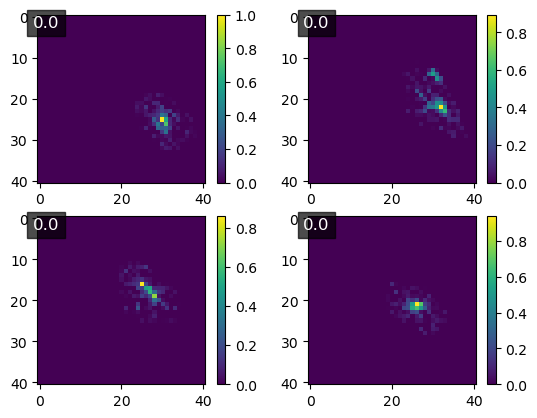

Min. and Max. Value for Image 1:  0.0  -  1.0 . Sum:  10.363396502917539
Min. and Max. Value for Image 2:  0.0  -  0.8936461579990982 . Sum:  12.808876107143133
Min. and Max. Value for Image 3:  0.0  -  0.8577130054577161 . Sum:  9.260933085420394
Min. and Max. Value for Image 4:  0.0  -  0.9382652010740916 . Sum:  9.055967576234027


In [27]:
plot_image_2by2(train_data_norm,4,train_labels_multishape,string="train",dt=formatted_datetime)

Overall Mean: -inf
Overall Max: 1.754969060156161e+308
Plotting Example Event. Event Nr:  4


/tmp/ipykernel_149970/2218016260.py:15: RuntimeWarning: invalid value encountered in divide
  test_data = test_data/max


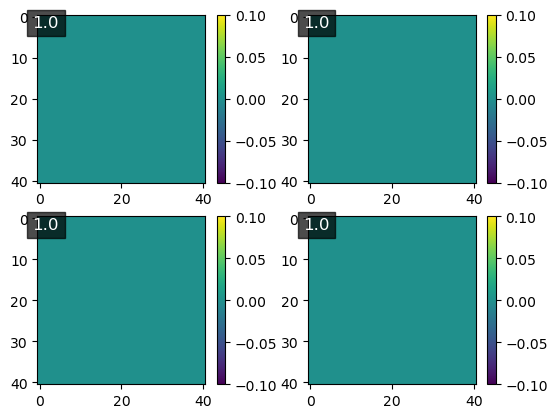

Min. and Max. Value for Image 1:  0.0  -  1.220152974550788e-307 . Sum:  8.352143091780012e-307
Min. and Max. Value for Image 2:  0.0  -  6.868841950675995e-307 . Sum:  2.5859856995658893e-306
Min. and Max. Value for Image 3:  0.0  -  9.486168406371185e-308 . Sum:  8.621232300022635e-307
Min. and Max. Value for Image 4:  0.0  -  0.0 . Sum:  0.0
Plotting Example Event. Event Nr:  4


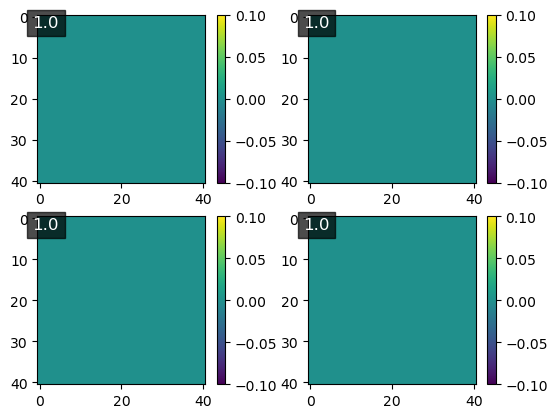

Min. and Max. Value for Image 1:  0.0  -  0.0 . Sum:  0.0
Min. and Max. Value for Image 2:  0.0  -  9.106933536268807e-308 . Sum:  7.111227812598194e-307
Min. and Max. Value for Image 3:  0.0  -  1.9887895512688413e-307 . Sum:  7.125648056332261e-307
Min. and Max. Value for Image 4:  0.0  -  1.2144790829144448e-307 . Sum:  6.762887799539359e-307


In [16]:
mean_values = np.mean(train_datanonan,axis=(2,3))
max_values = np.amax(train_datanonan,axis=(2,3))

mean = np.mean(mean_values)
max = np.max(max_values)

normalize = "norm"
print("Overall Mean:", mean)
print("Overall Max:", max)
#print(mean_values)
#print(max_values)

if normalize == "norm": 
    train_data = train_data/max
    test_data = test_data/max

plot_image_2by2(train_data,4,train_labels_multishape,string="train",dt=formatted_datetime)
plot_image_2by2(test_data,4,test_labels_multishape,string="test",dt=formatted_datetime)

In [7]:
mean_values = np.mean(train_data,axis=(2,3))
max_values = np.amax(train_data,axis=(2,3))

print(mean_values)
print(max_values)

[[[ 4.20018980e-001]
  [ 5.32303679e-001]
  [ 5.49427413e-001]
  [ 4.94041991e-001]]

 [[ 0.00000000e+000]
  [ 1.76571474e-001]
  [ 8.14530537e-002]
  [ 8.58183407e-002]]

 [[ 1.28792737e+000]
  [ 4.45182006e-001]
  [ 2.77060413e-001]
  [ 5.18518107e-001]]

 ...

 [[-2.25556868e+291]
  [ 4.80069830e+004]
  [-2.50442443e+294]
  [-6.26109724e+287]]

 [[-1.77538599e+304]
  [ 1.08402815e+299]
  [ 1.60719794e+285]
  [ 2.24519874e+005]]

 [[ 8.22977420e+287]
  [-3.57171267e+020]
  [-1.03208371e+300]
  [ 1.29200281e+005]]]
[[[1.08211884e+002]
  [1.23206047e+002]
  [1.74910660e+002]
  [1.55647705e+002]]

 [[0.00000000e+000]
  [2.51215115e+001]
  [1.25101480e+001]
  [2.61401215e+001]]

 [[1.69130508e+002]
  [4.93561707e+001]
  [3.31262779e+001]
  [6.56773071e+001]]

 ...

 [[3.70321932e+290]
  [1.67772201e+007]
  [8.11030757e+295]
  [3.45765745e+285]]

 [[3.48124587e+302]
  [1.82156463e+302]
  [2.70169974e+288]
  [1.70402464e+008]]

 [[1.38342515e+291]
  [1.55968487e-239]
  [3.33265160e+275]
  

/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/hanneswarnhofer/miniconda3/envs/HESSML_ENV2/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [7]:
print("##################################################################")
learning_rate = 0.001
num_epochs = 10
batch_size = 512

from keras import backend as K

opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.)

print("\n #####################   SINGLE VIEW MODEL   #######################")

inputs = Input(shape=input_shape)
base_cnn = create_custom_resnet(inputs,'BaseCNN')
single_view_model = create_single_model(base_cnn)

single_view_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#single_view_model.summary()
single_view_model.fit(filtered_data, filtered_labels, epochs=num_epochs, batch_size=batch_size,validation_data=(filtered_test_data,filtered_test_labels))


##################################################################

 #####################   SINGLE VIEW MODEL   #######################
Epoch 1/10


: 

In [6]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, AveragePooling2D
from keras.models import Model

input_shape = (41, 41, 1)
reg = 0.00001

def print_layer_dimensions(model):
    for layer in model.layers:
        print(f"Layer: {layer.name}, Input Shape: {layer.input_shape}")
        print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")
    print("#########################################################")
        

def create_custom_resnet_early_fromb0(inputs,model_name, dynamic_input_shape=False):
    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            input = Conv2D(filters, (1, 1), strides=strides, padding='same')(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3
    
    #if dynamic_input_shape:
    #    input_shape = inputs.shape.as_list()[1:]  # Get shape excluding batch size
    #    input_shape = tuple(input_shape)  # Convert to tuple
    #    inputs = Input(shape=input_shape)    
    #else: inputs = Input(shape=(None,11,11,1024))
    if dynamic_input_shape:
        if isinstance(inputs, list):
            input_shape = K.int_shape(inputs[0])[:]
            print(f"List input shape: {input_shape}")
        else:
            input_shape = K.int_shape(inputs)[:]
            print(f"Single input shape: {input_shape}")

        if len(input_shape) == 3:
            input_shape = (1,) + input_shape
            print(f"Updated input shape: {input_shape}")

    #inputs = Input(shape=input_shape) 

    b1 = outer_block(inputs,512,'B1')
    b2 = outer_block(b1,1024,'B2')
    b3 = outer_block(b2,2048,'B3')

    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(b3)

    #avgpool = GlobalAveragePooling2D()(x)
    outputs = Dense(units=1024, activation='softmax')(avgpool)

    model = Model(inputs=inputs, outputs=outputs, name=model_name)
    print_layer_dimensions(model)
    return model

def create_custom_resnet(inputs, model_name,start_layer=-1,freeze=False, dynamic_input_shape=False ):

    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            input = Conv2D(filters, (1, 1), strides=strides, padding='same')(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        




        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3

    if dynamic_input_shape:
        input_shape = inputs.shape.as_list()[1:]  # Get shape excluding batch size
        input_shape = tuple(input_shape)  # Convert to tuple
        inputs = Input(shape=input_shape)
        
    inputconv_name = model_name + "_InputConvolution"
    inputconv = Conv2D(64, (7, 7),strides = (2,2), padding='same',name=inputconv_name)(inputs)
    #maxpool = MaxPooling2D(strides=(2,2), padding='same')(inputconv)
    
    x = outer_block(inputconv, 1024,'B0')
        
    x = outer_block(x,512,'B1')
    x = outer_block(x,1024,'B2')
    x = outer_block(x,2048,'B3')
    #x = Flatten()(x)


    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(x)
    avgpoolname = model_name + "_GlobalAvgPool"
    #avgpool = GlobalAveragePooling2D(kernel_size=(2,2),name=avgpoolname)(x)
    densename = model_name + "_Dense1024softmax"
    dense = Dense(units=1024, activation='softmax')(avgpool)
    model = Model(inputs=inputs, outputs=dense,name=model_name)

    if start_layer != -1:
        for _ in range(0,start_layer):
            model.layers.pop(0)

    if freeze:
        for layer in model.layers:
            layer.trainable = False

    print_layer_dimensions(model)
            
    return model

def create_single_model(model):
    inputs = model.input
    x = model.output
    x = Dropout(0.5)(x)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_single = Model(inputs,outputs)
    print_layer_dimensions(model_single)
    return model_single

def create_latefc_model(models,inputs):
    fusionlayer = concatenate([model.output for model in models])
    x = Dropout(0.5)(fusionlayer)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    print_layer_dimensions(model_multi)
    return model_multi

def create_latemax_model(models,inputs):
    fusionlayer = Lambda(lambda x: tf.reduce_max(x, axis=0), output_shape=input_shape)([model.output for model in models])
    x = Dropout(0.5)(fusionlayer)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    print_layer_dimensions(model_multi)
    return model_multi

from keras import backend as K

def create_earlymax_model(models,inputs,block):

    if block == 0:
        nn1_block_idx = 15
        nn2_block = 'b1'
    elif block == 1:
        nn1_block_idx = 28
        nn2_block = 'b2'
    elif block == 2:
        nn1_block_idx = 42
        nn2_block = 'b3'    
    elif block == 3:
        nn1_block_idx = 56
        nn2_block = 'avgpool'
    else: print('Choose from b0 to b3 please')

    for model in models:
        print(model.layers[nn1_block_idx].output.shape)

    fusionlayer = concatenate([model.layers[nn1_block_idx].output for model in models],axis=-1)
    print("Fusionlayer:" ,fusionlayer.shape)
    fusionlayer = MaxPooling2D(pool_size=(4,1))(fusionlayer)
    print("Fusionlayer:" ,fusionlayer.shape)
    #input_shape_earlymax = (None,11,11,1024)
    #fusionlayer = Lambda(lambda x: tf.reduce_max(x, axis=-1), output_shape=input_shape)(fusionlayer)
    #fusionlayer = MaxPooling3D(pool_size=(1, 1, 4),padding='same')(fusionlayer)

    
    #def max_along_last_axis(x):
    #    return tf.reduce_max(x, axis=-1, keepdims=False)

    # Apply the custom function using Lambda layer
    #fused_feature_map = Lambda(max_along_last_axis)(fusionlayer)
    
    
    secondpart_model = create_custom_resnet_early_fromb0(fusionlayer,model_name="CNN2")

    x = Dropout(0.5)(secondpart_model.output)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    print_layer_dimensions(model_multi)

    return model_multi
    




# For example:


In [86]:
input_1 = Input(shape=input_shape)
cnn_model_1 = create_custom_resnet(input_1,'Model1')
input_2 = Input(shape=input_shape)
cnn_model_2 = create_custom_resnet(input_2,'Model2')
input_3 = Input(shape=input_shape)
cnn_model_3 = create_custom_resnet(input_3,'Model3')
input_4 = Input(shape=input_shape)
cnn_model_4 = create_custom_resnet(input_4,'Model4')    

learning_rate = 0.001
print("################################################################")
opt = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.)
model_multi = create_earlymax_model([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4],block="B0",ftype="earlyconv")
model_multi.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model_multi.summary()

################################################################
(None, 11, 11, 1024)
(None, 11, 11, 1024)
(None, 11, 11, 1024)
(None, 11, 11, 1024)
Fusionlayer after Concatenation: (None, 11, 11, 4096)
Fusionlayer after Reshape: (None, 11, 11, 1024, 4)
Fusionfilters:  1024
Fusionlayer after MaxPooling: (None, 11, 11, 4096)
Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_259 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_260 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_261 (InputLayer)         [(None, 41, 41, 1)]  0        

In [91]:
from keras.utils.vis_utils import plot_model
plot_model(model_multi,to_file="model_plot.png",show_shapes=True, show_layer_names=True)

In [220]:
num_epochs = 5
batch_size = 32

inputs = Input(shape=input_shape)
base_cnn = create_custom_resnet(inputs,'BaseCNN')
single_view_input = Input(shape=input_shape)
single_view_model = create_single_model(base_cnn)

single_view_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
single_view_model.summary()
#single_view_model.fit(filtered_data, filtered_labels, epochs=num_epochs, batch_size=batch_size,validation_data=(filtered_test_data,filtered_test_labels))

Layer: input_412, Input Shape: [(None, 41, 41, 1)]
Layer: input_412, Output Shape: [(None, 41, 41, 1)]
Layer: BaseCNN_InputConvolution, Input Shape: (None, 41, 41, 1)
Layer: BaseCNN_InputConvolution, Output Shape: (None, 21, 21, 64)
Layer: conv2d_14283, Input Shape: (None, 21, 21, 64)
Layer: conv2d_14283, Output Shape: (None, 21, 21, 1024)
Layer: batch_normalization_14035, Input Shape: (None, 21, 21, 1024)
Layer: batch_normalization_14035, Output Shape: (None, 21, 21, 1024)
Layer: BaseCNNB0_1_Conv1x1-A_firstblock, Input Shape: (None, 21, 21, 1024)
Layer: BaseCNNB0_1_Conv1x1-A_firstblock, Output Shape: (None, 11, 11, 256)
Layer: batch_normalization_14037, Input Shape: (None, 11, 11, 256)
Layer: batch_normalization_14037, Output Shape: (None, 11, 11, 256)
Layer: BaseCNNB0_1_ReLU-A, Input Shape: (None, 11, 11, 256)
Layer: BaseCNNB0_1_ReLU-A, Output Shape: (None, 11, 11, 256)
Layer: BaseCNNB0_1_Conv3x3-B, Input Shape: (None, 11, 11, 256)
Layer: BaseCNNB0_1_Conv3x3-B, Output Shape: (None, 1

In [82]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, AveragePooling2D
from keras.models import Model

input_shape = (41, 41, 1)
reg = 0.00001

def print_layer_dimensions(model):
    for layer in model.layers:
        print(f"Layer: {layer.name}, Input Shape: {layer.input_shape}")
        print(f"Layer: {layer.name}, Output Shape: {layer.output_shape}")
    print("#########################################################")

def create_custom_resnet(inputs, model_name,start_layer=-1,freeze=False, dynamic_input_shape=False ):

    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            input = Conv2D(filters, (1, 1), strides=strides, padding='same')(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        




        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3

    if dynamic_input_shape:
        input_shape = inputs.shape.as_list()[1:]  # Get shape excluding batch size
        input_shape = tuple(input_shape)  # Convert to tuple
        inputs = Input(shape=input_shape)
        
    inputconv_name = model_name + "_InputConvolution"
    inputconv = Conv2D(64, (7, 7),strides = (2,2), padding='same',name=inputconv_name)(inputs)
    #maxpool = MaxPooling2D(strides=(2,2), padding='same')(inputconv)
    
    x = outer_block(inputconv, 1024,'B0')
        
    x = outer_block(x,512,'B1')
    x = outer_block(x,1024,'B2')
    x = outer_block(x,2048,'B3')
    #x = Flatten()(x)


    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(x)
    avgpoolname = model_name + "_GlobalAvgPool"
    #avgpool = GlobalAveragePooling2D(kernel_size=(2,2),name=avgpoolname)(x)
    densename = model_name + "_Dense1024softmax"
    dense = Dense(units=1024, activation='softmax')(avgpool)
    model = Model(inputs=inputs, outputs=dense,name=model_name)

    if start_layer != -1:
        for _ in range(0,start_layer):
            model.layers.pop(0)

    if freeze:
        for layer in model.layers:
            layer.trainable = False

    #print_layer_dimensions(model)
            
    return model

def create_single_model(model):
    inputs = model.input
    x = model.output
    x = Dropout(0.5)(x)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_single = Model(inputs,outputs)
    #print_layer_dimensions(model_single)
    return model_single

def create_latefc_model(models,inputs):
    fusionlayer = concatenate([model.output for model in models])
    x = Dropout(0.5)(fusionlayer)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    #print_layer_dimensions(model_multi)
    return model_multi

def create_latemax_model(models,inputs):
    fusionlayer = Lambda(lambda x: tf.reduce_max(x, axis=0), output_shape=input_shape)([model.output for model in models])
    x = Dropout(0.5)(fusionlayer)
    #x = Flatten(x)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    #print_layer_dimensions(model_multi)
    return model_multi

def create_earlymax_model(models,inputs,ftype,block):
    
    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            inputconvname = bname + "_InpuConv"
            input = Conv2D(filters, (1, 1), strides=strides, padding='same',name=inputconvname)(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            firstblockconvname = bname + "_FirstBlockConv"
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same',name=firstblockconvname)(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3
    
    ## nn1_block_idx = 35 for Block 0_3 Final Activation Output
    #nn1_block_idx = 36

    layer1name = "Model1" + block + "_3_ReLU-Final"
    layer2name = "Model2" + block + "_3_ReLU-Final"
    layer3name = "Model3" + block + "_3_ReLU-Final"
    layer4name = "Model4" + block + "_3_ReLU-Final"
    nn1_block_names = [layer1name,layer2name,layer3name,layer4name]



    #nn1_block_names = ["Model1B1_3_ReLU-Final","Model2B1_3_ReLU-Final","Model3B1_3_ReLU-Final","Model4B1_3_ReLU-Final"]

    for  model, layer_name in zip(models, nn1_block_names):
        print(model.get_layer(name=layer_name).output.shape)

    #layer_outputs =     [model.layers[nn1_block_idx].output for model in models]

    #nn1_block_names = ["Model1B1_3_ReLU-Final", "Model2B1_3_ReLU-Final", "Model3B1_3_ReLU-Final", "Model4B1_3_ReLU-Final"]
    layer_outputs = [model.get_layer(name=layer_name).output for model, layer_name in zip(models, nn1_block_names)]

    fusionlayer = Concatenate(axis=-1)(layer_outputs)
    print("Fusionlayer after Concatenation:" ,fusionlayer.shape)

    #fusionlayer = Reshape((11, 11, 1024, 4))(fusionlayer)
    #fusionlayer = Reshape((*fusionlayer.shape[1:],4))(fusionlayer)
    fusionlayer = Reshape((fusionlayer.shape[1], fusionlayer.shape[2], fusionlayer.shape[3] // 4, 4))(fusionlayer)

    print("Fusionlayer after Reshape:" ,fusionlayer.shape)

    max_pooling_function = Lambda(lambda x: K.max(x, axis=-1, keepdims=False))
    fusionfilters = fusionlayer.shape[3]
    print("Fusionfilters: ",fusionfilters)
      
    #fusionlayer = Conv3D(filters=fusionfilters, kernel_size=(1, 1, 4*fusionfilters), strides = (1,1,1), activation='relu',padding="same")(fusionlayer)
    
    if ftype == "earlyconv":
        conv2d_list = []
        for i in range(4):  # Assuming you have 4 channels
            slice_layer = Lambda(lambda x: x[:, :, :, i])(fusionlayer)
            conv2d = Conv2D(filters=fusionfilters, kernel_size=(1, 1), padding='same', activation='relu')(slice_layer)
            conv2d_list.append(conv2d)
            #fusionlayer = conv2d_list
        fusionlayer= concatenate(conv2d_list, axis=-1)
    elif ftype == "earlymax":     
        fusionlayer = max_pooling_function(fusionlayer) 
    else: print ("Fusiontype earlymax or earlyconv must be specified")
    # Concatenate the results along the channel axis
    
    
    
    
    print("Fusionlayer after MaxPooling:",fusionlayer.shape)

    model_name = "CNN2"

    if block == "B0":
        b1 = outer_block(fusionlayer,512,'B1')
        b2 = outer_block(b1,1024,'B2')
        b3 = outer_block(b2,2048,'B3')
    elif block == "B1":
        b2 = outer_block(fusionlayer,1024,'B2')
        b3 = outer_block(b2,2048,'B3')
    elif block == "B2":
        b3 = outer_block(fusionlayer,2048,'B3')   
    elif block == "B3":
        b3 = fusionlayer
    else: print('Choose from B0 to B3 please!')

    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(b3)
    dense1024 = Dense(units=1024, activation='softmax')(avgpool)

    x = Dropout(0.5)(dense1024)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    #print_layer_dimensions(model_multi)

    return model_multi

input_1 = Input(shape=input_shape)
cnn_model_1 = create_custom_resnet(input_1,'Model1')
input_2 = Input(shape=input_shape)
cnn_model_2 = create_custom_resnet(input_2,'Model2')
input_3 = Input(shape=input_shape)
cnn_model_3 = create_custom_resnet(input_3,'Model3')
input_4 = Input(shape=input_shape)
cnn_model_4 = create_custom_resnet(input_4,'Model4')    

print("################################################################")




################################################################


In [83]:
model_multi = create_earlymax_model([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4],"earlymax","B0")
model_multi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_multi.summary()

(None, 11, 11, 1024)
(None, 11, 11, 1024)
(None, 11, 11, 1024)
(None, 11, 11, 1024)
Fusionlayer after Concatenation: (None, 11, 11, 4096)
Fusionlayer after Reshape: (None, 11, 11, 1024, 4)
Fusionfilters:  1024
Fusionlayer after MaxPooling: (None, 11, 11, 1024)
Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_247 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_248 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_249 (InputLayer)         [(None, 41, 41, 1)]  0           []                               
                            

In [46]:
def create_earlymax_model_b1(models,inputs):
    
    def inner_block(input, filters,outer_nr,inner_nr, strides=(1, 1), firstblock = False,):
        shortcut = input

        bname = model_name + outer_nr + inner_nr

        if input.shape[-1] != filters:
            inputconvname = bname + "_InpuConv"
            input = Conv2D(filters, (1, 1), strides=strides, padding='same',name=inputconvname)(input)
            input = BatchNormalization()(input)    

        if firstblock == True: 
            xaname = bname + "_Conv1x1-A_firstblock"
            xa = Conv2D(filters // 4, (1, 1), strides=(2,2), padding='same',name=xaname)(input)
            firstblockconvname = bname + "_FirstBlockConv"
            shortcut = Conv2D(filters, (1, 1), strides=(2,2), padding='same',name=firstblockconvname)(shortcut)
            shortcut = BatchNormalization()(shortcut)
        else: 
            xaname = bname + "_Conv1x1-A"
            xa = Conv2D(filters // 4, (1, 1), strides=strides, padding='same',name=xaname)(input)

        xbname = bname + "_BatchNorm-A" 
        xb = BatchNormalization()(xa)
        xcname = bname + "_ReLU-A" 
        xc = Activation('relu',name=xcname)(xb)
        xdname = bname + "_Conv3x3-B" 
        xd = Conv2D(filters // 4, (3, 3), strides=strides, padding='same',name = xdname)(xc)
        xename = bname + "_BatchNorm-B"
        xe = BatchNormalization()(xd)
        xfname = bname + "_ReLU-B"
        xf = Activation('relu',name=xfname)(xe)
        xgname = bname +"_Conv1x1-C"
        xg = Conv2D(filters, (1, 1), strides=strides, padding='same',name=xgname)(xf)
        xhname = bname + "_BatchNorm-C"
        xh = BatchNormalization()(xg)

        xiname = bname + "_ResidualConnection"
        xi = Add()([xh, shortcut])
        xjname = bname + "_ReLU-Final"
        xj = Activation('relu',name=xjname)(xi)
        return xj
    
    def outer_block(input,num_filters,block_nr):
        x1 = inner_block(input,num_filters,block_nr,'_1',firstblock=True)
        x2 = inner_block(x1,num_filters,block_nr,'_2')
        x3 = inner_block(x2,num_filters,block_nr,'_3')
        return x3
    
    ## nn1_block_idx = 34 for Block 0_3 Final Activation Output
    nn1_block_idx = 69 #Try searching by name


    for model in models:
        print(model.layers[nn1_block_idx].output.shape)

    layer_outputs =     [model.layers[nn1_block_idx].output for model in models]

    fusionlayer = Concatenate(axis=-1)(layer_outputs)
    print("Fusionlayer after Concatenation:" ,fusionlayer.shape)

    fusionlayer = Reshape((fusionlayer.shape[1], fusionlayer.shape[2], fusionlayer.shape[3] // 4, 4))(fusionlayer)
    print("Fusionlayer after Reshape:" ,fusionlayer.shape)

    max_pooling_function = Lambda(lambda x: K.max(x, axis=-1, keepdims=False))
    fusionlayer = max_pooling_function(fusionlayer)   
    print("Fusionlayer after MaxPooling:",fusionlayer.shape)

    model_name = "CNN2"
    #b1 = outer_block(fusionlayer,512,'B1')
    b2 = outer_block(fusionlayer,1024,'B2')
    b3 = outer_block(b2,2048,'B3')

    avgpool = Lambda(lambda x: K.mean(x, axis=(1, 2), keepdims=False))(b3)
    dense1024 = Dense(units=1024, activation='softmax')(avgpool)

    x = Dropout(0.5)(dense1024)
    outputs = Dense(units=1, activation='sigmoid')(x)
    model_multi = Model(inputs,outputs)
    print_layer_dimensions(model_multi)

    return model_multi

input_1 = Input(shape=input_shape)
cnn_model_1 = create_custom_resnet(input_1,'Model1')
input_2 = Input(shape=input_shape)
cnn_model_2 = create_custom_resnet(input_2,'Model2')
input_3 = Input(shape=input_shape)
cnn_model_3 = create_custom_resnet(input_3,'Model3')
input_4 = Input(shape=input_shape)
cnn_model_4 = create_custom_resnet(input_4,'Model4')    

print("################################################################")

model_multi = create_earlymax_model_b1([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
model_multi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_multi.summary()

Layer: input_155, Input Shape: [(None, 41, 41, 1)]
Layer: input_155, Output Shape: [(None, 41, 41, 1)]
Layer: Model1_InputConvolution, Input Shape: (None, 41, 41, 1)
Layer: Model1_InputConvolution, Output Shape: (None, 21, 21, 64)
Layer: conv2d_1334, Input Shape: (None, 21, 21, 64)
Layer: conv2d_1334, Output Shape: (None, 21, 21, 1024)
Layer: batch_normalization_7390, Input Shape: (None, 21, 21, 1024)
Layer: batch_normalization_7390, Output Shape: (None, 21, 21, 1024)
Layer: Model1B0_1_Conv1x1-A_firstblock, Input Shape: (None, 21, 21, 1024)
Layer: Model1B0_1_Conv1x1-A_firstblock, Output Shape: (None, 11, 11, 256)
Layer: batch_normalization_7392, Input Shape: (None, 11, 11, 256)
Layer: batch_normalization_7392, Output Shape: (None, 11, 11, 256)
Layer: Model1B0_1_ReLU-A, Input Shape: (None, 11, 11, 256)
Layer: Model1B0_1_ReLU-A, Output Shape: (None, 11, 11, 256)
Layer: Model1B0_1_Conv3x3-B, Input Shape: (None, 11, 11, 256)
Layer: Model1B0_1_Conv3x3-B, Output Shape: (None, 11, 11, 256)
La

In [36]:
num_epochs = 5
batch_size = 64

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(filtered_data, filtered_labels, epochs=num_epochs, batch_size=batch_size,validation_data=(filtered_test_data,filtered_test_labels))

NameError: name 'model' is not defined

In [7]:
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.layers import Input, Concatenate, concatenate, Dense,Embedding, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, ConvLSTM2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import Model, Sequential

input_shape = (41, 41, 1)
pool_size = 2
kernel_size = 4
rate = 0.002
reg = 0.0001
num_epochs = 10
batch_size = 128

# Define the model for the single-view CNNs
def create_cnn_model(input_shape):
    input_layer = Input(shape=input_shape)
    Conv1 = Conv2D(filters=200, kernel_size=kernel_size, padding='same',kernel_regularizer=regularizers.l2(reg), input_shape=input_shape,)(input_layer)
    LeakyRelu1 = LeakyReLU(alpha=0.1)(Conv1)
    MaxPool1 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu1)

    #print("Before first Dropout")

    Dropout1 = Dropout(rate)(MaxPool1)
    Conv2 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout1)
    LeakyRelu2 = LeakyReLU(alpha=0.1)(Conv2) 
    MaxPool2 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu2)

    Dropout2 = Dropout(rate)(MaxPool2)
    Conv3 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout2)
    LeakyRelu3 = LeakyReLU(alpha=0.1)(Conv3) 
    MaxPool3 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu3)

    Dropout3 = Dropout(rate)(MaxPool3)
    Conv4 = Conv2D(filters=50, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout3)
    LeakyRelu4 = LeakyReLU(alpha=0.1)(Conv4) 
    MaxPool4 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu4)

    Dropout4 = Dropout(rate)(MaxPool4)
    Conv5 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout4)
    LeakyRelu5 = LeakyReLU(alpha=0.1)(Conv5) 
    MaxPool5 = MaxPooling2D(pool_size=pool_size, padding='same')(LeakyRelu5)

    Dropout5 = Dropout(rate)(MaxPool5)
    Conv6 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout5)
    MaxPool6 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv6)

    Dropout6 = Dropout(rate)(MaxPool6)
    Conv7 = Conv2D(filters=100, kernel_size=kernel_size,padding='same', kernel_regularizer=regularizers.l2(reg))(Dropout6)
    MaxPool7 = MaxPooling2D(pool_size=pool_size, padding='same')(Conv7)

    model = Model(inputs=input_layer, outputs=MaxPool7)

    return model

# Define the model for the combination of the previous CNNs and the final CNN for classification

def run_multiview_model(models,inputs):

    merged = concatenate(models)

    Dropout1 = Dropout(rate)(merged)
    Conv_merged1 = Conv2D(filters=100,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout1)
    MaxPool_merged1 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged1)

    Dropout2 = Dropout(rate)(MaxPool_merged1)
    Conv_merged2 = Conv2D(filters=50,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout2)
    MaxPool_merged2 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged2)

    Dropout3 = Dropout(rate)(MaxPool_merged2)
    Conv_merged3 = Conv2D(filters=80,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout3)
    MaxPool_merged3 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged3)

    Dropout31 = Dropout(rate)(MaxPool_merged3)
    Conv_merged31 = Conv2D(filters=140,kernel_size=[2,2],activation='relu',padding='same',input_shape=input_shape)(Dropout31)
    MaxPool_merged31 = MaxPooling2D(pool_size=2,padding='same')(Conv_merged31)

    Flat_merged1 = Flatten()(MaxPool_merged31)
    Dropout4 = Dropout(rate)(Flat_merged1)
    dense_layer_merged1 = Dense(units=100, activation='relu')(Dropout4)

    Dropout6 = Dropout(rate)(dense_layer_merged1)
    dense_layer_merged3 = Dense(units=1, activation='sigmoid')(Dropout6)

    model = Model(inputs=inputs, outputs=dense_layer_merged3)
    return model

# Create four separate CNN models
input_1 = Input(shape=input_shape)
cnn_model_1 = create_cnn_model(input_shape)(input_1)

input_2 = Input(shape=input_shape)
cnn_model_2 = create_cnn_model(input_shape)(input_2)

input_3 = Input(shape=input_shape)
cnn_model_3 = create_cnn_model(input_shape)(input_3)

input_4 = Input(shape=input_shape)
cnn_model_4 = create_cnn_model(input_shape)(input_4)

# include early_stopping here, to see how it changes compared to previous model designs
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

model_multi = run_multiview_model([cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4],[input_1, input_2, input_3, input_4])
model_multi.summary()
model_multi.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) 

history = model_multi.fit([train_data[:,i,:,:] for i in range(4)],train_labels,epochs=num_epochs,batch_size=batch_size,validation_data=([test_data[:,i,:,:] for i in range(4)], test_labels), callbacks=[early_stopping])

# Create the filename, which is used for saving the Accuracy and Loss plots and the history files

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 41, 41, 1)]  0           []                               
                                                                                           

KeyboardInterrupt: 

: 